In [1]:
import multiprocessing
import warnings
import os
import gc
import random
import itertools
import pickle
import time
from datetime import datetime
from pathlib import Path
from collections import Counter
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# visualization 
import seaborn as sns
import matplotlib.pyplot as plt

# data preprocessing 
from itertools import product
import pandas as pd
import numpy as np
import missingno
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle

# model
import xgboost as xgb
import lightgbm as lgb
import catboost as cb 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

# eveluation 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# hyperparameters tuning 
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

# utils
import sys
sys.path.insert(0, '/tf/notebooks/other/kaggle')
from utils import utils_featexp
from utils import utils_features_engineering
from utils import utils_features_plots
from utils import utils_reduce_memory
from utils import utils_statistic

warnings.filterwarnings('ignore')
seed = 9527

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
main_path = Path('../input/ieee-cis-fraud-detection/')

with open(str(main_path / 'train_df.pkl'), 'rb') as handle:
    train_df = pickle.load(handle)
    
with open(str(main_path / 'test_df.pkl'), 'rb') as handle:
    test_df = pickle.load(handle)    

In [3]:
print('Number of train data:{}'.format(train_df.shape))
print('Number of test data:{}'.format(test_df.shape))

Number of train data:(590540, 441)
Number of test data:(506691, 440)


# Feature Engineering

* Define cols

In [5]:
target_col = 'isFraud'
redundant_cols = ['P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'TransactionDT', 'tran_date']
features_cols = [c for c in train_df.columns.tolist() if c not in redundant_cols + ['TransactionID', 'isFraud']]
cat_features = [i for i in features_cols if str(train_df[i].dtype) in ['object', 'category']]

* Load knn feature data

In [4]:
train_knn_feats_df = np.load(str(main_path / 'knn_feats_minkowski_train.npy'))
test_knn_feats_df = np.load(str(main_path / 'knn_feats_minkowski_test.npy'))

In [5]:
knn_cols = ['knn_' + str(i) for i in range(train_knn_feats_df.shape[1])]
train_knn_df = pd.DataFrame(train_knn_feats_df, columns=knn_cols)
test_knn_df = pd.DataFrame(test_knn_feats_df, columns=knn_cols)
del train_knn_feats_df, test_knn_feats_df

* Label encoding

In [25]:
enc = LabelEncoder()
for f in cat_features:
    if train_df[f].dtype =='O': 
        df1_tmp = train_df[f].fillna('NaN')
        df2_tmp = test_df[f].fillna('NaN')        
        enc.fit(np.concatenate([df1_tmp.values, df2_tmp.values], axis=0).astype(str))
        train_df[f] = enc.transform(df1_tmp.values)
        test_df[f] = enc.transform(df2_tmp.values)

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

In [26]:
train_df['is_this_transaction_in_test_data'] = 0
test_df['is_this_transaction_in_test_data'] = 1

In [27]:
all_df = pd.concat([train_df[features_cols + ['is_this_transaction_in_test_data']], 
                    test_df[features_cols + ['is_this_transaction_in_test_data']]], axis=0)

In [28]:
num_of_iter = 10000
num_early_stopping = 200
num_verbose_eval = 500

metric = 'auc'

lgb_sk_params = {
    'boosting_type': 'gbdt', # goss, dart
    #'num_leaves': 80,
    #'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': num_of_iter,
    #'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'objective': 'binary',
    'metrics': [metric], # binary_logloss
    #'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    #'min_child_weight': 1,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    #'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    #'subsample': 0.8,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 3,  # L1 regularization term on weights
    #'reg_lambda': 0.191472,
    'random_state': seed,
    'n_jobs': multiprocessing.cpu_count(),
    #'scale_pos_weight': 7.369937,
    #'max_bin': 255
}

In [29]:
target_col = 'is_this_transaction_in_test_data'
select_features_cols = features_cols

In [30]:
%%time
n_splits = 3
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
Kflods = folds.split(all_df[select_features_cols].values, all_df[target_col].values)
#folds = TimeSeriesSplit(n_splits=n_splits)
#Kflods = folds.split(train_df[select_features_cols].values, train_df[target_col].values)

oof = np.zeros(len(all_df))
feature_importance_df = pd.DataFrame()
total_fold_loss_df = pd.DataFrame()
target_encoding_cols = None
model_name = 'lgb'
mean_enc = None

for fold, (trn_idx, val_idx) in enumerate(Kflods):
    print("===== Fold {} =====".format(fold))
    trn_idx = shuffle(trn_idx)
    train_x, train_y = all_df.iloc[trn_idx][select_features_cols], all_df.iloc[trn_idx][target_col]
    valid_x, valid_y = all_df.iloc[val_idx][select_features_cols], all_df.iloc[val_idx][target_col]
    features_cols_v2 = select_features_cols.copy()

    eval_set = [(train_x[features_cols_v2], train_y), (valid_x[features_cols_v2], valid_y)]
    
    cv_model = lgb.LGBMClassifier(**lgb_sk_params)    
    cv_model.fit(X=train_x[features_cols_v2],
                 y=train_y, 
                 eval_set=eval_set,    
                 eval_names=['validation_0', 'validation_1'],
                 early_stopping_rounds=num_early_stopping, 
                 #categorical_feature=cat_features,
                 verbose=num_verbose_eval) 
    loss = cv_model.evals_result_.items()

    
    # loss 
    fold_loss_df = pd.DataFrame(columns=['fold', 'type', 'loss'])
    for k, v in loss:
        if k == 'validation_0' or k == 'learn':        
            fold_loss_df['loss'] = v[list(v.keys())[0]]
            fold_loss_df['fold'] = fold + 1
            fold_loss_df['type'] = 'train'                
        elif k == 'validation_1' or k == 'validation':
            fold_loss_df['loss'] = v[list(v.keys())[0]]
            fold_loss_df['fold'] = fold + 1
            fold_loss_df['type'] = 'valid'                
        total_fold_loss_df = pd.concat([total_fold_loss_df, fold_loss_df], axis=0)
    
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features_cols_v2
    fold_importance_df["importance"] = cv_model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # evaluation
    oof[val_idx] += cv_model.predict_proba(valid_x[features_cols_v2], 
                                           ntree_limit=cv_model.best_iteration_)[:, 1]


print()     
print('## Valid-CV AUC: {:.4f}'.format(roc_auc_score(all_df[target_col].values, oof)))    

===== Fold 0 =====
Training until validation scores don't improve for 200 rounds.
[500]	validation_0's auc: 0.939835	validation_1's auc: 0.934796
[1000]	validation_0's auc: 0.951262	validation_1's auc: 0.943217
[1500]	validation_0's auc: 0.958353	validation_1's auc: 0.947803
[2000]	validation_0's auc: 0.963524	validation_1's auc: 0.950875
[2500]	validation_0's auc: 0.967815	validation_1's auc: 0.953299
[3000]	validation_0's auc: 0.971234	validation_1's auc: 0.955106
[3500]	validation_0's auc: 0.97408	validation_1's auc: 0.956579
[4000]	validation_0's auc: 0.976539	validation_1's auc: 0.957881
[4500]	validation_0's auc: 0.978642	validation_1's auc: 0.95898
[5000]	validation_0's auc: 0.980532	validation_1's auc: 0.959941
[5500]	validation_0's auc: 0.982327	validation_1's auc: 0.960787
[6000]	validation_0's auc: 0.983943	validation_1's auc: 0.961596
[6500]	validation_0's auc: 0.985132	validation_1's auc: 0.962128
[7000]	validation_0's auc: 0.986364	validation_1's auc: 0.962706
[7500]	vali

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'LGB Features importance (averaged/folds)')

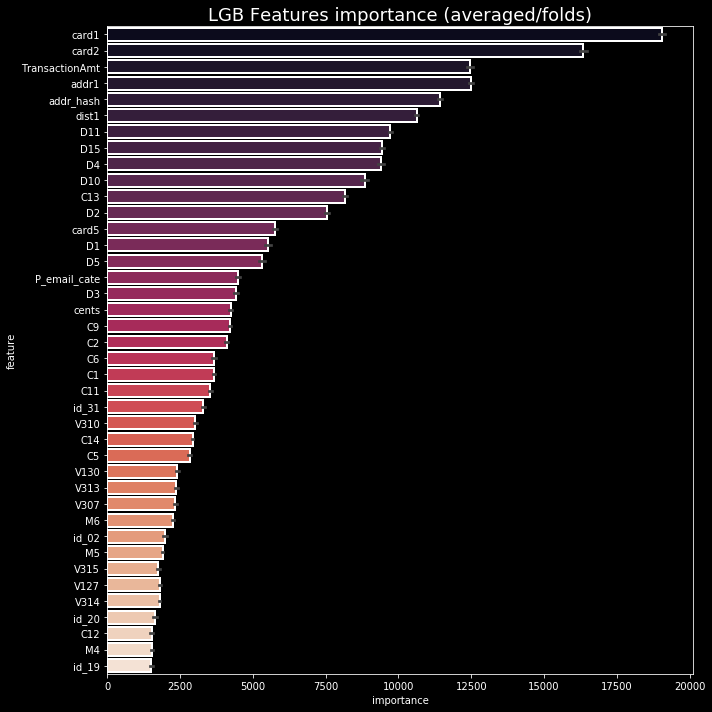

In [37]:
plt.style.use('dark_background')
cols = (feature_importance_df[["feature", "importance"]]
    .groupby("feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:40].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2, palette="rocket")
plt.title('LGB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

In [38]:
cols

Index(['card1', 'card2', 'addr1', 'TransactionAmt', 'addr_hash', 'dist1',
       'D11', 'D15', 'D4', 'D10', 'C13', 'D2', 'card5', 'D1', 'D5',
       'P_email_cate', 'D3', 'cents', 'C9', 'C2', 'C1', 'C6', 'C11', 'id_31',
       'V310', 'C14', 'C5', 'V130', 'V313', 'V307', 'M6', 'id_02', 'M5',
       'V314', 'V127', 'V315', 'id_20', 'M4', 'C12', 'id_19'],
      dtype='object', name='feature')

* **Card columns**

In [8]:
train_df, enc_value, prior_mean, feature_name = utils_features_engineering.mean_encoding(data_x=train_df, 
                                                                                         data_y=train_df[target_col], 
                                                                                         feature='card1', 
                                                                                         target=target_col)
test_df[feature_name] = test_df['card1'].map(enc_value)

In [9]:
for feature in ['card2', 'card3', 'card5']:
    count_feature = 'c_{}'.format(feature)
    train_df[count_feature] = train_df[feature].map(train_df[feature].value_counts(dropna=False))
    test_df[count_feature] = test_df[feature].map(train_df[feature].value_counts(dropna=False))

In [ ]:
for i in [do_count, do_count_unique, do]
train_df = do_count(data=train_df, 
                    group_cols=['card4'], 
                    target_col='TransactionAmt', 
                    new_col_name='n_tran_card4', 
                    col_type=np.int8)


In [ ]:
train_df = do_count(data=train_df, 
                    group_cols=['card6'], 
                    target_col='TransactionAmt', 
                    new_col_name='n_tran_card4', 
                    col_type=np.int8)

* **D columns**

* **C columns**

* **M columns**

* **V columns**

* **Other columns**

* **Interaction**

# Baseline model

In [86]:
num_of_iter = 10000
num_early_stopping = 200
num_verbose_eval = 500

metric = 'auc'
weight_ratio = (train_df.shape[0] - sum(train_df.isFraud)) / sum(train_df.isFraud) 
#weight_ratio = 10

xgb_sk_params = {
    'learning_rate': 0.1,
    'n_estimators': num_of_iter,                                   
    'objective': 'binary:logistic', # binary:logistic
    'n_jobs': multiprocessing.cpu_count(),
    #'tree_method': "gpu_hist",  # gpu_hist
    #'n_gpus': -1,
    'eval_metric': [metric], # logloss
    'random_state':  seed,
    #'verbosity ': 0,
    #'gamma': 1.718862, # Minimum loss reduction required to make a further partition on a leaf node of the tree, alias min_split_loss. It acts as a regularization parameter. Either 0, 1 or 5.
    #'max_depth': 3, # 0 means no limit (useful only for depth wise grow policy).
    #'min_child_weight': 156, # Minimum sum of instance weight (hessian) needed in a child.
    #'subsample': 0.729009, # Subsample ratio of the training instances.
    #'colsample_bytree': 0.884221, # subsample ratio of columns when constructing each tree.
    #'colsample_bylevel': 0.034, # subsample ratio of columns for each level.
    #'reg_lambda': 1e-3, # L2 regularization. Increasing this value will make model more conservative.
    #'reg_alpha': 0, # L1 regularization. Increasing this value will make model more conservative.
    #'scale_pos_weight': weight_ratio, # Control the balance of positive and negative weights, useful for unbalanced classes.
    #'grow_policy': "lossguide", # split at nodes with highest loss change.
    #'max_leaves': 255, # Maximum number of nodes to be added. (for lossguide grow policy).
    'max_bin': 115, # Increasing this number improves the optimality of splits at the cost of higher computation time.
}

lgb_sk_params = {
    'boosting_type': 'gbdt', # goss, dart
    #'num_leaves': 80,
    #'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': num_of_iter,
    #'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'objective': 'binary',
    'metrics': [metric], # binary_logloss
    #'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    #'min_child_weight': 1,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    #'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    #'subsample': 0.8,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 3,  # L1 regularization term on weights
    #'reg_lambda': 0.191472,
    'random_state': seed,
    'n_jobs': multiprocessing.cpu_count(),
    #'scale_pos_weight': 7.369937,
    #'max_bin': 255
}

cat_sk_params = {
    'loss_function': 'Logloss',
    'iterations': num_of_iter,
    'learning_rate': 0.1,
    'random_state': seed,
    #'l2_leaf_reg': 0.01,
    #'bootstrap_type': 'Bayesian',
    #'subsample': 0.8, # only use at bootstrap type is [Poisson, Bernoulli]
    'use_best_model': True,
    #'depth': 5,
    #'one_hot_max_size': 31,
    #'colsample_bylevel': 0.8,
    #'leaf_estimation_method': 'Gradient', # [Newton, Gradient]
    #'class_weights': [1, 0.9038461538461537],
    #'max_bin': 128, # alias max_bin
    'thread_count': multiprocessing.cpu_count()    
}

In [64]:
select_features_cols = features_cols + knn_cols

In [ ]:
%%time
n_splits = 5
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
Kflods = folds.split(train_df[select_features_cols].values, train_df[target_col].values)
#folds = TimeSeriesSplit(n_splits=n_splits)
#Kflods = folds.split(train_df[select_features_cols].values, train_df[target_col].values)

oof = np.zeros(len(train_df))
feature_importance_df = pd.DataFrame()
total_fold_loss_df = pd.DataFrame()
y_pred = np.zeros(test_df.shape[0])
target_encoding_cols = None
model_name = 'lgb'
mean_enc = None

time_split_trn_ratio = []
time_split_val_ratio = []

for fold, (trn_idx, val_idx) in enumerate(Kflods):
    print("===== Fold {} =====".format(fold))
    trn_idx = shuffle(trn_idx)
    train_x, train_y = train_df.iloc[trn_idx][select_features_cols], train_df.iloc[trn_idx][target_col]
    valid_x, valid_y = train_df.iloc[val_idx][select_features_cols], train_df.iloc[val_idx][target_col]
    features_cols_v2 = select_features_cols.copy()

    #time_split_trn_ratio.append(train_y.sum() / train_y.count())
    #time_split_val_ratio.append(valid_y.sum() / valid_y.count())
    if mean_enc == 'mean':
        for f in target_encoding_cols:
            train_x, enc_value, prior_mean, feature_name = mean_encoding(train_x, train_y, f, target_col)
            valid_x[feature_name] = valid_x[f].map(enc_value)
            valid_x[feature_name].fillna(prior_mean, inplace=True)    
            test_df[feature_name] = test_df[f].map(enc_value)
            test_df[feature_name].fillna(prior_mean, inplace=True)
            eatures_cols_v2.remove(f)
            features_cols_v2.append(feature_name)
    elif mean_enc == 'smooth':
        for f in target_encoding_cols:
            train_x, enc_value, prior_mean, feature_name = smooth_mean_encoding(train_x, train_y, f, target_col, 
                                                                                smooth_method='sigmoid_smooth')
            valid_x[feature_name] = valid_x[f].map(enc_value)
            valid_x[feature_name].fillna(prior_mean, inplace=True)    
            test_df[feature_name] = test_df[f].map(enc_value)
            test_df[feature_name].fillna(prior_mean, inplace=True)
            features_cols_v2.remove(f)
            features_cols_v2.append(feature_name)
    elif mean_enc == 'beta':
        prior_mean = np.mean(train_y)
        for f in target_encoding_cols:
            stats = train_df.iloc[trn_idx].groupby(f).agg(['sum', 'count'])['label'].reset_index()
            train_x, feature_name = beta_mean_encoding(train_x, f, target_col, stats, prior_mean)
            valid_x, _ = beta_mean_encoding(valid_x, f, target_col, stats, prior_mean)
            test_df, _ = beta_mean_encoding(test_df, f, target_col, stats, prior_mean)
            features_cols_v2.remove(f)
            features_cols_v2.append(feature_name)

    eval_set = [(train_x[features_cols_v2], train_y), (valid_x[features_cols_v2], valid_y)]
    
    if model_name == 'xgb':
        xgb_sk_params.update({'random_state': fold + np.random.randint(999) + seed})
        cv_model = xgb.XGBClassifier(**xgb_sk_params)
        cv_model.fit(X=train_x[features_cols_v2],
                     y=train_y, 
                     eval_set=eval_set,             
                     early_stopping_rounds=num_early_stopping, 
                     verbose=num_verbose_eval) 
        loss = cv_model.evals_result().items()
        
    elif model_name == 'lgb':
        cv_model = lgb.LGBMClassifier(**lgb_sk_params)    
        cv_model.fit(X=train_x[features_cols_v2],
                     y=train_y, 
                     eval_set=eval_set,    
                     eval_names=['validation_0', 'validation_1'],
                     early_stopping_rounds=num_early_stopping, 
                     #categorical_feature=cat_features
                     verbose=num_verbose_eval) 
        loss = cv_model.evals_result_.items()
    elif model_name == 'cat':
        cv_model = cb.CatBoostClassifier(**cat_sk_params, od_type='Iter', od_wait=20)
        eval_set = [(valid_x[features_cols_v2], valid_y)]
        cv_model.fit(X=train_x[features_cols_v2],
                     y=train_y,
                     eval_set=eval_set,
                     #cat_features=cat_features,
                     early_stopping_rounds=num_early_stopping, 
                     verbose=num_verbose_eval,
                     plot=False)
        loss = cv_model.evals_result_.items()
    
    # loss 
    fold_loss_df = pd.DataFrame(columns=['fold', 'type', 'loss'])
    for k, v in loss:
        if k == 'validation_0' or k == 'learn':        
            fold_loss_df['loss'] = v[list(v.keys())[0]]
            fold_loss_df['fold'] = fold + 1
            fold_loss_df['type'] = 'train'                
        elif k == 'validation_1' or k == 'validation':
            fold_loss_df['loss'] = v[list(v.keys())[0]]
            fold_loss_df['fold'] = fold + 1
            fold_loss_df['type'] = 'valid'                
        total_fold_loss_df = pd.concat([total_fold_loss_df, fold_loss_df], axis=0)
    
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features_cols_v2
    fold_importance_df["importance"] = cv_model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # evaluation
    if model_name == 'xgb':
        oof[val_idx] += cv_model.predict_proba(valid_x[features_cols_v2], 
                                               ntree_limit=cv_model.best_iteration)[:, 1]
        y_pred += cv_model.predict_proba(test_df[features_cols_v2], 
                                         ntree_limit=cv_model.best_iteration)[:, 1] / folds.n_splits
    elif model_name == 'lgb':
        oof[val_idx] += cv_model.predict_proba(valid_x[features_cols_v2], 
                                               ntree_limit=cv_model.best_iteration_)[:, 1]
        y_pred += cv_model.predict_proba(test_df[features_cols_v2], 
                                         ntree_limit=cv_model.best_iteration_)[:, 1] / folds.n_splits
    elif model_name == 'cat':   
        oof[val_idx] += cv_model.predict_proba(valid_x[features_cols_v2], 
                                               ntree_end=cv_model.best_iteration_)[:, 1]
        y_pred += cv_model.predict_proba(test_df[features_cols_v2], 
                                         ntree_end=cv_model.best_iteration_)[:, 1] / folds.n_splits 

print()     
print('## Valid-CV AUC: {:.4f}'.format(roc_auc_score(train_df[target_col].values, oof)))    

In [85]:
report = classification_report(train_df[target_col].values, oof >= 0.5, target_names=['0', '1'])
print('Classification  report:')
print(report)


Classification  report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     20663
           1       1.00      0.40      0.57     20663

    accuracy                           0.70     41326
   macro avg       0.81      0.70      0.67     41326
weighted avg       0.81      0.70      0.67     41326



Text(0.5, 0, 'Iteration')

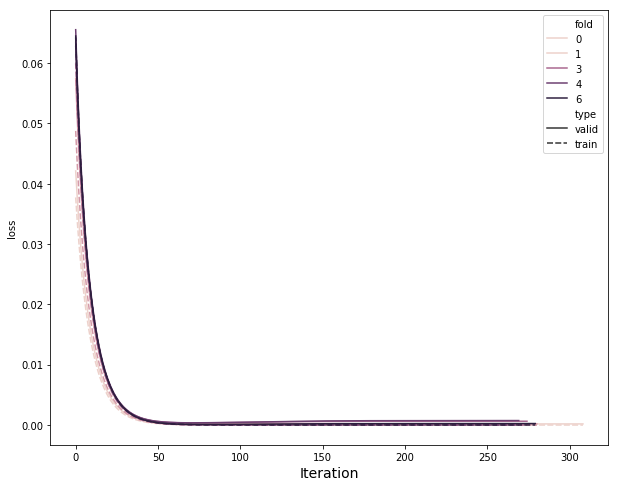

In [68]:
total_fold_loss_df = total_fold_loss_df.reset_index()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
palette = sns.color_palette("Paired", fold)
sns.lineplot(x='index', y='loss', hue='fold', style='type', 
             data=total_fold_loss_df, ax=ax)
ax.set_xlabel('Iteration', fontsize=14)    

In [ ]:
plt.style.use('dark_background')
cols = (feature_importance_df[["feature", "importance"]]
    .groupby("feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:40].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2, palette="rocket")
plt.title('LGB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

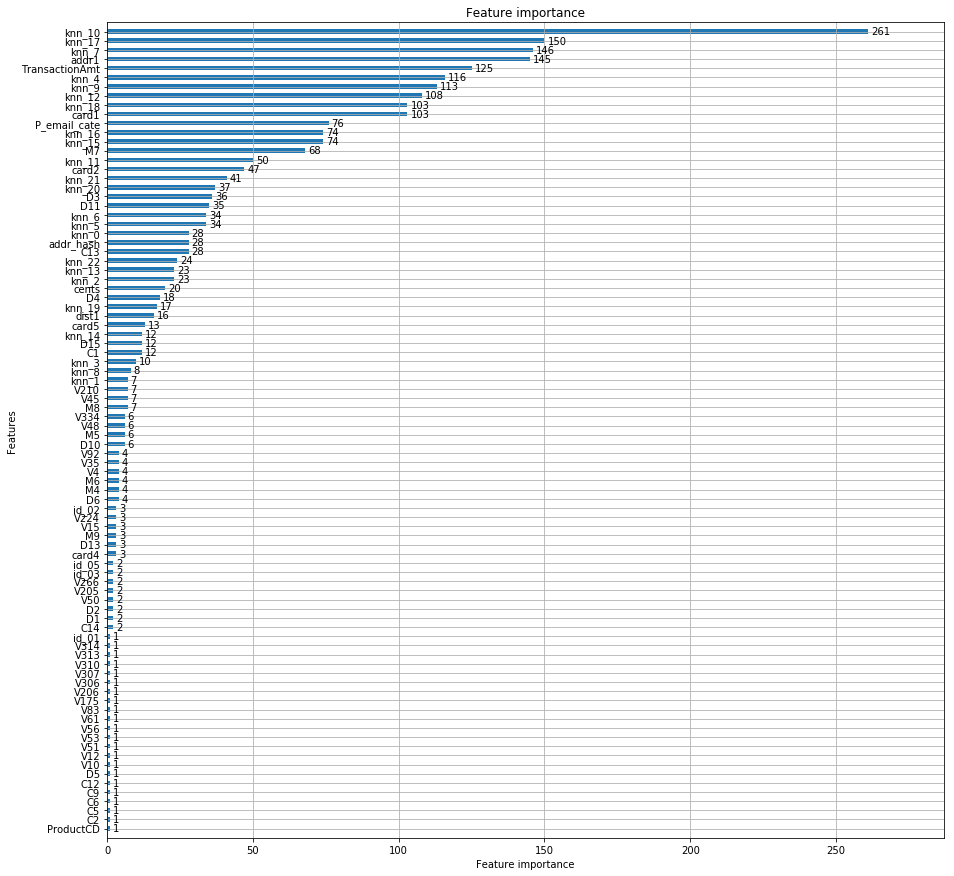

In [69]:
fig, ax = plt.subplots(figsize=(15, 15))
lgb.plot_importance(cv_model, max_num_features=100, height=0.5, importance_type='split', ax=ax)

#fimp_df = feature_importance_df.groupby('feature')['importance'].mean()\
#    .reset_index()\
#    .sort_values('importance', ascending=False)

#fig, ax = plt.subplots(1, 1, figsize=(12, 10))
#pal = sns.color_palette("Paired", fimp_df.shape[0])
#g = sns.barplot(x="importance", y="feature", 
#                palette=pal,
#                data=fimp_df,
#                ax=ax)

In [70]:
submit_name = 'sample_data'
file_name = 'submission_{}.csv'.format(submit_name)
submission_df = test_df[['TransactionID']]
submission_df['isFraud'] = y_pred
submission_df.to_csv(file_name, header=True, index=False, mode='w')

# Feature selection

* Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
* Improves Accuracy: Less misleading data means modeling accuracy improves.
* Reduces Training Time: fewer data points reduce algorithm complexity and algorithms train faster.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import copy

fe_train_data = copy.deepcopy(train_df)
fe_train_data.fillna(0, inplace=True)
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, 
                                                             random_state=seed))
embeded_rf_selector.fit(fe_train_data[features_cols], fe_train_data[target_col])

In [ ]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = fe_train_data[features_cols].loc[:, embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
del fe_train_data

# Cross validation

In [ ]:
%%time
n_splits = 5
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
Kflods = folds.split(train_df[features_cols].values, train_df[target_col].values)
#folds = TimeSeriesSplit(n_splits=5)
#Kflods = folds.split(train_df[features_cols].values, train_df[target_col].values)

oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()
total_fold_loss_df = pd.DataFrame()
y_true = test_df[target_col].values.tolist()
y_pred = np.zeros(test_df.shape[0])
test_acc_score = []
test_auc_score = []
encoding_cols = ['c_in', 'c_out', 'c_t_in', 'c_t_out', 'TW']
target_encoding_cols = [f for f in features_cols if f in encoding_cols]
model_name = 'xgb'
mean_enc = None

time_split_trn_ratio = []
time_split_val_ratio = []

for fold, (trn_idx, val_idx) in enumerate(Kflods):
    print("===== Fold {} =====".format(fold))
    trn_idx = shuffle(trn_idx)
    train_x, train_y = train_df.iloc[trn_idx][features_cols], train_df.iloc[trn_idx][target_col]
    valid_x, valid_y = train_df.iloc[val_idx][features_cols], train_df.iloc[val_idx][target_col]
    features_cols_v2 = features_cols.copy()

    time_split_trn_ratio.append(train_y.sum() / train_y.count())
    time_split_val_ratio.append(valid_y.sum() / valid_y.count())
    if mean_enc == 'mean':
        for f in target_encoding_cols:
            train_x, enc_value, prior_mean, feature_name = mean_encoding(train_x, train_y, f, target_col)
            valid_x[feature_name] = valid_x[f].map(enc_value)
            valid_x[feature_name].fillna(prior_mean, inplace=True)    
            test_df[feature_name] = test_df[f].map(enc_value)
            test_df[feature_name].fillna(prior_mean, inplace=True)
            #features_cols_v2.remove(f)
            features_cols_v2.append(feature_name)
    elif mean_enc == 'smooth':
        for f in target_encoding_cols:
            train_x, enc_value, prior_mean, feature_name = smooth_mean_encoding(train_x, train_y, f, target_col, 
                                                                                smooth_method='sigmoid_smooth')
            valid_x[feature_name] = valid_x[f].map(enc_value)
            valid_x[feature_name].fillna(prior_mean, inplace=True)    
            test_df[feature_name] = test_df[f].map(enc_value)
            test_df[feature_name].fillna(prior_mean, inplace=True)
            #features_cols_v2.remove(f)
            features_cols_v2.append(feature_name)
    elif mean_enc == 'beta':
        prior_mean = np.mean(train_y)
        for f in target_encoding_cols:
            stats = train_df.iloc[trn_idx].groupby(f).agg(['sum', 'count'])['label'].reset_index()
            train_x, feature_name = beta_mean_encoding(train_x, f, target_col, stats, prior_mean)
            valid_x, _ = beta_mean_encoding(valid_x, f, target_col, stats, prior_mean)
            test_df, _ = beta_mean_encoding(test_df, f, target_col, stats, prior_mean)
            #features_cols_v2.remove(f)
            features_cols_v2.append(feature_name)

    eval_set = [(train_x[features_cols_v2], train_y), (valid_x[features_cols_v2], valid_y)]
    
    if model_name == 'xgb':
        xgb_sk_params.update({'random_state': fold + np.random.randint(999) + seed})
        cv_model = xgb.XGBClassifier(**xgb_sk_params)
        cv_model.fit(X=train_x[features_cols_v2],
                     y=train_y, 
                     eval_set=eval_set,             
                     early_stopping_rounds=num_early_stopping, 
                     verbose=num_verbose_eval) 
        loss = cv_model.evals_result().items()
        
    elif model_name == 'lgb':
        cv_model = lgb.LGBMClassifier(**lgb_sk_params)    
        cv_model.fit(X=train_x[features_cols_v2],
                     y=train_y, 
                     eval_set=eval_set,    
                     eval_names=['validation_0', 'validation_1'],
                     early_stopping_rounds=num_early_stopping, 
                     verbose=num_verbose_eval,
                     categorical_feature=bin_features) 
        loss = cv_model.evals_result_.items()
    elif model_name == 'cat':
        cv_model = cb.CatBoostClassifier(**cat_sk_params, od_type='Iter', od_wait=20)
        eval_set = [(valid_x[features_cols_v2], valid_y)]
        cv_model.fit(X=train_x[features_cols_v2],
                     y=train_y,
                     eval_set=eval_set,
                     #cat_features=cat_features,
                     early_stopping_rounds=num_early_stopping, 
                     verbose=num_verbose_eval,
                     plot=False)
        loss = cv_model.evals_result_.items()
    
    # loss 
    fold_loss_df = pd.DataFrame(columns=['fold', 'type', 'loss'])
    for k, v in loss:
        if k == 'validation_0' or k == 'learn':        
            fold_loss_df['loss'] = v[list(v.keys())[0]]
            fold_loss_df['fold'] = fold + 1
            fold_loss_df['type'] = 'train'                
        elif k == 'validation_1' or k == 'validation':
            fold_loss_df['loss'] = v[list(v.keys())[0]]
            fold_loss_df['fold'] = fold + 1
            fold_loss_df['type'] = 'valid'                
        total_fold_loss_df = pd.concat([total_fold_loss_df, fold_loss_df], axis=0)
    
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features_cols_v2
    fold_importance_df["importance"] = cv_model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # evaluation
    if model_name == 'xgb':
        oof[val_idx] += cv_model.predict_proba(valid_x[features_cols_v2], 
                                               ntree_limit=cv_model.best_iteration)[:, 1]
        y_pred += cv_model.predict_proba(test_df[features_cols_v2], 
                                         ntree_limit=cv_model.best_iteration)[:, 1] / folds.n_splits
    elif model_name == 'lgb':
        oof[val_idx] += cv_model.predict_proba(valid_x[features_cols_v2], 
                                               ntree_limit=cv_model.best_iteration_)[:, 1]
        y_pred += cv_model.predict_proba(test_df[features_cols_v2], 
                                         ntree_limit=cv_model.best_iteration_)[:, 1] / folds.n_splits
    elif model_name == 'cat':   
        oof[val_idx] += cv_model.predict_proba(valid_x[features_cols_v2], 
                                               ntree_end=cv_model.best_iteration_)[:, 1]
        y_pred += cv_model.predict_proba(test_df[features_cols_v2], 
                                         ntree_end=cv_model.best_iteration_)[:, 1] / folds.n_splits        
        
    test_acc_score.append(accuracy_score(y_true, y_pred >= 0.5))
    test_auc_score.append(roc_auc_score(y_true, y_pred))
    

print()    
print('## Valid-CV Accuracy: {:.4f}'.format(accuracy_score(train_df[target_col].values, oof >= 0.5)))    
print('## Valid-CV AUC: {:.4f}'.format(roc_auc_score(train_df[target_col].values, oof)))    
print()   
print('## Test-CV Accuracy: {:.4f}'.format(np.array(test_acc_score).mean()))    
print('## Test-CV AUC: {:.4f}'.format(np.array(test_auc_score).mean()))  
       

# HPO